In [94]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%



 Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

 ### Importing Skin Cancer Data
 #### To do: Take necessary actions to read the data

 ### Importing all the important libraries

In [95]:
import Augmentor
from IPython import get_ipython
from IPython.display import display

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import sys
from pathlib2 import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import kerastuner as kt
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.python.client import device_lib
from glob import glob
import shutil

In [96]:


def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']


get_available_devices()


['/device:CPU:0', '/device:GPU:0']

 This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [97]:
root_folder = Path().resolve()
images_path = root_folder / "Skin cancer ISIC The International Skin Imaging Collaboration"
images_path



WindowsPath('F:/UpgradLearning/06Deep Learning/03CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration')

In [98]:
# Defining the path for train and test images
# Todo: Update the paths of the train and test dataset
data_dir_train = images_path / "Train"
data_dir_test = images_path / "Test"



In [99]:
train_image_file_names = list(data_dir_train.glob('*/*.jpg'))
image_count_train = len(train_image_file_names)
print(image_count_train)
test_image_file_names = list(data_dir_test.glob('*/*.jpg'))
image_count_test = len(test_image_file_names)
print(image_count_test)


2239
118


 ### Load using keras.preprocessing

 Let's load these images off disk using the helpful image_dataset_from_directory utility.

 ### Create a dataset

 Define some parameters for the loader:

In [100]:
batch_size = 32
img_height = 180
img_width = 180
SEED = 123
image_size = (img_height, img_width)
epochs = 20
validation_split = 0.2
input_shape = (img_height, img_width, 3)


 Use 80% of the images for training, and 20% for validation.

In [101]:
# Write your train dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, seed=SEED, image_size=image_size, batch_size=batch_size, validation_split=validation_split, subset="training", )
train_ds


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [102]:
# Write your validation dataset here
# Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
# Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_test, seed=SEED, image_size=image_size, batch_size=batch_size, subset="validation", validation_split=validation_split)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [103]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(sorted(class_names))


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


 ### Visualize the data
 #### Todo, create a code to visualize one instance of all the nine classes present in the dataset

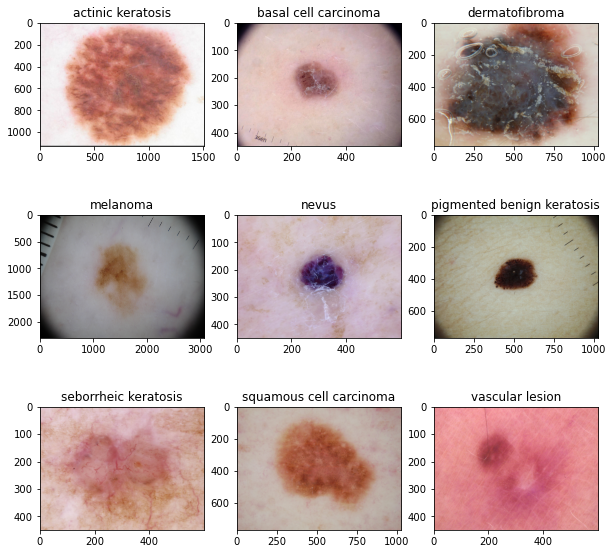

In [104]:

fig = plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    class_name = class_names[i]
    img_dir = data_dir_train / class_name
    img_num = np.random.randint(image_count_train)
    im = plt.imread(str(train_image_file_names[img_num]))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

 The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

 `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

 `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [105]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


 ### Create the model
 #### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [106]:
#  Rescaling is used as part of model

num_classes = len(class_names)


def build_model(input_shape, num_classes):
    model = Sequential([
        #  Rescaling : to bring values between [0,1]
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])
    return model


model = build_model(input_shape=(img_height, img_width, 3), num_classes=len(class_names))

 ### Compile the model
 Choose an appropriate optimizer and loss function for model training

In [107]:
# Todo, choose an appropriate optimizer and loss function


def complie_model(model):
    """Compiles model for image classification with adam optimizer, SparseCategoricalCrossentropy and accuracy

    Args:
        model ([Any]): Sequential model

    Returns:
        Any: complied Model
    """
    model.compile(optimizer="rmsprop",  # adam gave similar results, however with sgd model remained underfit
                  loss=SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


def train_model(model, train_ds, val_ds, epochs: int = 20, callbacks=None):
    """Trains CNN model

    Args:
        model ([Any]): Compiled model
        train_ds ([Any]): Training dataset
        val_ds ([Any]): Validation dataset
        epochs ([int]): Number of epochs

    Returns:
        [Any]: Training history
    """
    if callbacks:
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    else:
        history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history


def compile_and_train_model(model, train_ds, val_ds, epochs):
    """Compiles model for image classification with sgd optimizer, SparseCategoricalCrossentropy and accuracy, display model summary and Trains CNN model

    Args:
        model ([Any]): Compiled model
        train_ds ([Any]): Training dataset
        val_ds ([Any]): Validation dataset
        epochs ([int]): Number of epochs

    Returns:
        [Any]: Training history
    """
    model = complie_model(model)
    display(model.summary())
    history = train_model(model, train_ds, val_ds, epochs)
    return history, model



In [108]:
history, model = compile_and_train_model(model, train_ds, val_ds, epochs)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 22, 22, 64)       

None

Epoch 1/20
56/56 [==============================] - 15s 41ms/step - loss: 2.9230 - accuracy: 0.2038 - val_loss: 2.5704 - val_accuracy: 0.0000e+00
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.9765 - accuracy: 0.3073 - val_loss: 3.4581 - val_accuracy: 0.1304
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8053 - accuracy: 0.3808 - val_loss: 2.8726 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5939 - accuracy: 0.4437 - val_loss: 2.1691 - val_accuracy: 0.1739
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4359 - accuracy: 0.5051 - val_loss: 2.7931 - val_accuracy: 0.2174
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4252 - accuracy: 0.4962 - val_loss: 2.7597 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3273 - accuracy: 0.5337 - val_loss: 2.5237 - val_accuracy: 0.2609
Epoch 8/

In [109]:
# View the summary of all layers
model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 22, 22, 64)       

 ### Train the model
  trained above

 ### Visualizing training results

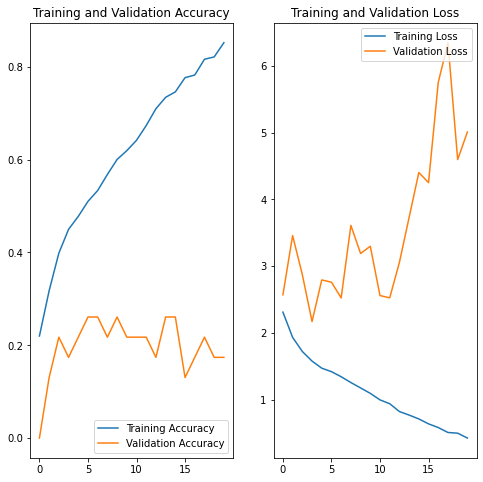

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


 #### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**We could draw below conclusions**
    - **rmsprop and adam** optimizers gave similar results **(overfitting the model)**
    - however with **sgd** model **remained underfit**
    - For this experimentation I am going with rmsprop optimizer
    - **As we can see that both training and validations accuracy are apart from each other, while training accuracy touching 90%, validation accuracy is fluctuating between 20-30% this shows that model is kind of overfit**

In [111]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augmentation strategy.

In [112]:
# Your code goes here
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1, 0.1),
        RandomTranslation(0.1, 0.1)
    ]
)


In [113]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

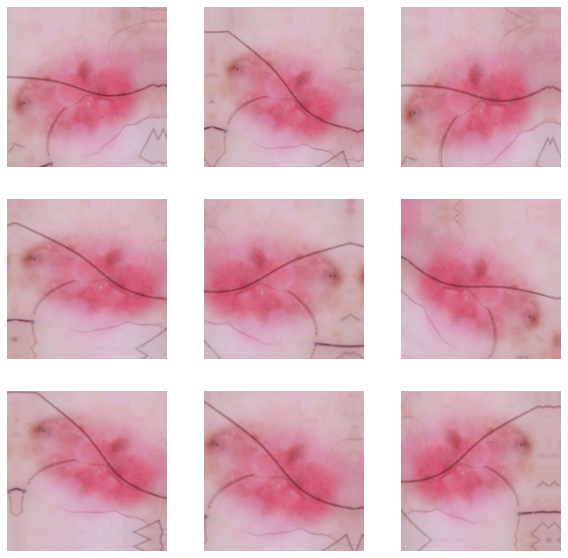

In [114]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


 ### Create the model, compile and train the model

In [115]:
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
])


In [116]:
# Did in previous cell : You can use Dropout layer if there is an evidence of overfitting in your findings


In [117]:
# Your code goes here, note: train your model for 20 epochs
# Compiling and training model, augmentation is part of model building
history, model = compile_and_train_model(model, train_ds, val_ds, epochs)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 45, 45, 128)     

None

Epoch 1/20
56/56 [==============================] - 4s 45ms/step - loss: 3.1574 - accuracy: 0.1866 - val_loss: 2.5296 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 2.0654 - accuracy: 0.2352 - val_loss: 2.9300 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.9183 - accuracy: 0.2911 - val_loss: 2.2776 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7744 - accuracy: 0.3582 - val_loss: 2.1832 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7447 - accuracy: 0.3778 - val_loss: 2.1903 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.6138 - accuracy: 0.4244 - val_loss: 1.9887 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6081 - accuracy: 0.4214 - val_loss: 2.1806 - val_accuracy: 0.3043
Epoch 8/20
56

 ### Visualizing the results

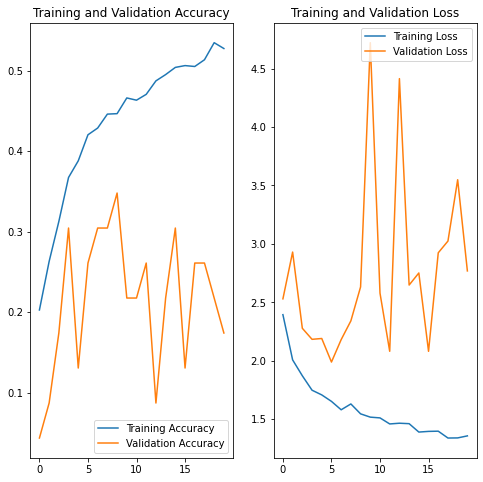

In [118]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


 #### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**In both plots we can see that there are similar trend however there are below things which we could see **
 - There is a bit more stability in validation accuracy, most of time it remained towards 30s
 - The gap between Training and validation accuracy is significantly lower than previous experiment
 - Validation accuracy with augmented data is a bit in lower range
 - Model is **towards underfit now** as even training accuracy now could reaching to 60%

 #### **Todo:** Find the distribution of classes in the training dataset.
 #### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

,Class,Image Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


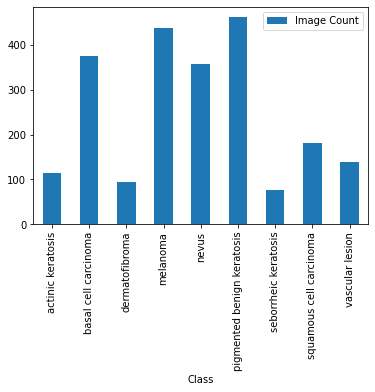

In [119]:

all_dirs = []
file_counts = []
for base, dirs, files in os.walk(data_dir_train):
    for d in dirs:
        all_dirs.append(d)
    if not base.endswith("Train"):
        file_counts.append(len([f for f in files]))
file_count_df = pd.DataFrame(zip(all_dirs, file_counts), columns=["Class", "Image Count"])
display(file_count_df)
file_count_df.plot.bar(x='Class', y='Image Count')
plt.show()


In [120]:
file_count_df.sort_values(by="Image Count", ascending=False)

,Class,Image Count
5,pigmented benign keratosis,462
3,melanoma,438
1,basal cell carcinoma,376
4,nevus,357
7,squamous cell carcinoma,181
8,vascular lesion,139
0,actinic keratosis,114
2,dermatofibroma,95
6,seborrheic keratosis,77


 #### **Todo:** Write your findings here:
- Which class has the least number of samples?
    - **seborrheic keratosis** with count **77**
- Which classes dominate the data in terms proportionate number of samples?
     - **pigmented benign keratosis** with count **462**

 #### **Todo:** Rectify the class imbalance
 #### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [121]:
# get_ipython().system('pip install Augmentor --no-cache-dir')


 To use `Augmentor`, the following general procedure is followed:

 1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
 2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
 3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [122]:
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(500)


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26848CF2C40>:   1%|          | 4/500 [00:00<00:50,  9.90 Samples/s]                  Initialised with 114 image(s) found.
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x26814FCDC10>: 100%|██████████| 500/500 [00:03<00:00, 127.37 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x265C859D790>:   1%|          | 4/500 [00:00<01:00,  8.13 Samples/s]Initialised with 376 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26847E25130>: 100%|██████████| 500/500 [00:03<00:00, 134.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x26814FCD910>:   2%|▏         | 8/500 [00:00<00:52,  9.29 Samples/s]                  Initialised with 95 image(s) found.
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x265C859DFD0>: 100%|██████████| 500/500 [00:04<00:00, 121.65 Samples/s]
Executing Pipeline:   0%|          | 0

 Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [123]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


 ### Lets see the distribution of augmented data after adding new images to the original training data.

In [124]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list[:5]



['F:\\UpgradLearning\\06Deep Learning\\03CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_363b6cf8-f8e0-4a8b-9953-c4ed487f96b0.jpg',
 'F:\\UpgradLearning\\06Deep Learning\\03CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_525a6f81-698f-4451-859c-4e348d27a5c1.jpg',
 'F:\\UpgradLearning\\06Deep Learning\\03CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b1705963-6412-4a93-b440-3842623fe071.jpg',
 'F:\\UpgradLearning\\06Deep Learning\\03CNN Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b6625c46-3055-4e02-90f8-9061cba7f499.jpg',
 'F:\\UpgradLearning\\06Deep Learnin

In [125]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
lesion_list_new[:5]



['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [126]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [127]:
original_df = pd.DataFrame([(str(p), str(p.parent).split("\\")[-1]) for p in train_image_file_names], columns=['Path', 'Label'])
original_df.head()

,Path,Label
0,F:\UpgradLearning\06Deep Learning\03CNN Assign...,actinic keratosis
1,F:\UpgradLearning\06Deep Learning\03CNN Assign...,actinic keratosis
2,F:\UpgradLearning\06Deep Learning\03CNN Assign...,actinic keratosis
3,F:\UpgradLearning\06Deep Learning\03CNN Assign...,actinic keratosis
4,F:\UpgradLearning\06Deep Learning\03CNN Assign...,actinic keratosis


In [128]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = original_df.append(df2)



In [129]:
new_df['Label'].value_counts()


pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

 So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

 #### **Todo**: Train the model on the data created using Augmentor

In [130]:
#  Commenting these as these variables are declayered globally
# batch_size = 32
# img_height = 180
# img_width = 180

In [131]:
# Lets make new traininf location
new_train_path = images_path/"AugTrain"
new_train_path_str = str(new_train_path)
if os.path.exists(new_train_path_str):
    shutil.rmtree(new_train_path_str)
os.mkdir(new_train_path_str)


In [132]:
for c in new_df['Label'].unique():
    class_path = new_train_path/c
    if not os.path.exists(class_path):
        os.mkdir(class_path)
    for f in list(new_df[new_df['Label'] == c]['Path']):
        shutil.copy(f, class_path)



 #### **Todo:** Create a training dataset

In [133]:
data_dir_train = new_train_path  # "path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=SEED,
    validation_split=validation_split,
    subset='training',  # Todo choose the correct parameter value, so that only training data is refereed to,
    image_size=image_size,
    batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


 #### **Todo:** Create a validation dataset

In [134]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=SEED,
    validation_split=validation_split,
    subset='validation',  # Todo choose the correct parameter value, so that only validation data is refereed to,
    image_size=image_size,
    batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


 #### **Todo:** Create your model (make sure to include normalization)

In [135]:


def build_model(input_shape, num_classes):
    model = Sequential([
        #  Rescaling : to bring values between [0,1]
        Rescaling(1./255, input_shape=input_shape),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.22),
        Conv2D(128, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(256, 3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(128, 3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes)
    ])
    return model


model = build_model(input_shape=input_shape, num_classes=len(class_names))



 #### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [136]:
model = complie_model(model)
display(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 45, 45, 64)      

None

 #### **Todo:**  Train your model

In [137]:
epochs = 70
# Your code goes here, use 50 epochs.
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')
]
# history = train_model(model, train_ds, val_ds, epochs, callbacks=callbacks)
history = train_model(model, train_ds, val_ds, epochs)


Epoch 1/70
169/169 [==============================] - 42s 235ms/step - loss: 2.1971 - accuracy: 0.1400 - val_loss: 2.0914 - val_accuracy: 0.1789
Epoch 2/70
169/169 [==============================] - 40s 230ms/step - loss: 1.9939 - accuracy: 0.2314 - val_loss: 1.7008 - val_accuracy: 0.3601
Epoch 3/70
169/169 [==============================] - 37s 216ms/step - loss: 1.7578 - accuracy: 0.3471 - val_loss: 1.5320 - val_accuracy: 0.4217
Epoch 4/70
169/169 [==============================] - 38s 216ms/step - loss: 1.6386 - accuracy: 0.3711 - val_loss: 1.4440 - val_accuracy: 0.4261
Epoch 5/70
169/169 [==============================] - 38s 216ms/step - loss: 1.5790 - accuracy: 0.4019 - val_loss: 1.4576 - val_accuracy: 0.4425
Epoch 6/70
169/169 [==============================] - 39s 223ms/step - loss: 1.4841 - accuracy: 0.4283 - val_loss: 1.4289 - val_accuracy: 0.4350
Epoch 7/70
169/169 [==============================] - 38s 217ms/step - loss: 1.4664 - accuracy: 0.4484 - val_loss: 1.5284 - val_ac

 #### **Todo:**  Visualize the model results

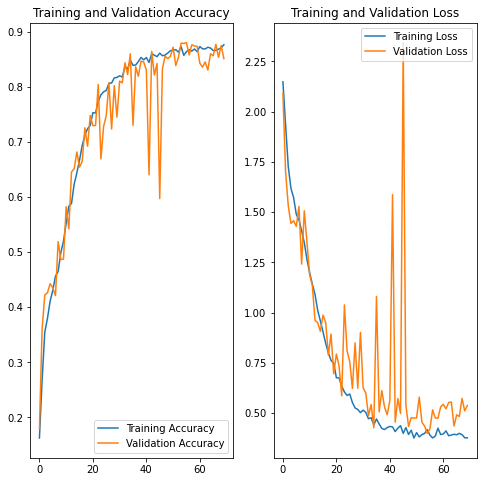

In [138]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**I ran the model with multiple mentioned configurations, Observations are below:**  

| Configuration  | Observations   |
| :---        | :---        |
| Simple Model | Even simple model with augmenter performed much better than without augmenter that means **More the data we'll have better model** |
| With one extra layer | Added one extra layer as validation accuracy kept fluctuating |
| With Dropout | Added one drop outlayer with 0.2 and found that validation accuracy was a bit stabilized |
| Added more layers and dropputs| Training of network became much stable accuracy and validation accuracy followed tightly together, so decided to increase the epochs and observe |
| With Callback | Added two callbacks for saving the model and early stopping, model did stop on epoch number and with validation accuracy |

**Found that with 70 epochs accuracy and validation accuracy settled around 85% and 87% respectively, model looked fairly stable so stopped training**     